<img src="Images/1200px-University_of_Tehran_logo.svg.png" width="100" style="float:left;"/>

<img src="Images/fanni.png" width="120" style="float:right;position: relative;top: -25px;"/>


<h1 style="float:center;" align="center">Computer Assignment 3</h1>
<h3 style="float:center;" align="center"><b> Navid Akbari ( 810895023 ) </b></h3>

The goal of this computer assignment is to get more familiar with the Naive Bayes Classification. This algorithm help us to classify between different categories easily. In this CA we want to classify different news categories.

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.corpus
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')
pd.set_option('mode.chained_assignment', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, we read the data from .csv file and check the data info.

In [2]:
fields=['category', 'short_description']
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Attachment/data.csv', usecols=fields)
data.head()

,category,short_description
0,TRAVEL,Påskekrim is merely the tip of the proverbial ...
1,BUSINESS,NaN
2,STYLE & BEAUTY,"Madonna is slinking her way into footwear now,..."
3,TRAVEL,But what if you're a 30-something couple that ...
4,BUSINESS,Obamacare was supposed to make birth control f...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22925 entries, 0 to 22924
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           22925 non-null  object
 1   short_description  21703 non-null  object
dtypes: object(2)
memory usage: 358.3+ KB


As you see there exists some null object in the dataset, so we should delete them.

In [4]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21703 entries, 0 to 22924
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           21703 non-null  object
 1   short_description  21703 non-null  object
dtypes: object(2)
memory usage: 508.7+ KB


# Data Preprocessing
Next step in each ML problem is to clean data and prepare it for making the best usage of it. Here I define a `normalize` function which clean data. First I convert all the words in the data set to lower case, then I eliminate all symbols except alphabets. After that I delete stop words from the dataset. Stop words are the words which are very common in English language and also they don't have any specific meaning like: I, me, you, etc. Then I tokenize sentences and run the lemmatizer and stemmer method on the words.
## Stemming
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

## Lemmatization
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

At the end I remove unneeded columns.

## Comparison

As is shown in the below diagram, Theres is not any huge difference between using Stemming and Lemmatization here in our data set. I decide to use the Lemmatization only.

| Lemmatization | Stemming | Both Stemming and Lemmatization |
| --- | --- | --- |
| <img src="Images/letlower.png" width="300px"/> | <img src="Images/stemlow.png" width="300px"/>  | <img src="Images/bothlow.png" width="300px"/> |

| None of the Stemming and Lemmatization | Not Lower Case |
| --- | --- |
| <img src="Images/non.png" width="300px"/> | <img src="Images/notlower.png" width="300px"/>  |

In [5]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

def normalize(data):
    stop_words = stopwords.words('english')

    data['clean_data'] = data['short_description'].str.lower()
    data['clean_data'] = data['short_description'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    data['clean_data'] = data['clean_data'].apply(lambda elem: re.sub(r"\d+", "", elem))
    data['clean_data'] = data['clean_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    data['text_tokens'] = data['clean_data'].apply(lambda x: word_tokenize(x))
    data['text_tokens'] = data['text_tokens'].apply(lambda x: word_lemmatizer(x)) 
    # data['text_tokens'] = data['text_tokens'].apply(lambda x: word_stemmer(x))
    data = data.drop(columns=['short_description', 'clean_data'])
    
    return data


data = normalize(data)
data.head()

,category,text_tokens
0,TRAVEL,"[Pskekrim, merely, tip, proverbial, iceberg, O..."
2,STYLE & BEAUTY,"[Madonna, slinking, way, footwear, Truth, Dare..."
3,TRAVEL,"[But, youre, something, couple, shy, away, tab..."
4,BUSINESS,"[Obamacare, supposed, make, birth, control, fr..."
5,STYLE & BEAUTY,"[Madonna, previously, released, Truth, Dare, f..."


# Split Train set and Test set
First, we need to separate our data into two parts of train set and test set. 80% of data is considered as train set. We choose a random subset for train and test so that it is not sorted in any specific order and it can represent the entire news collection better. Also it is better to split data equally in each category because it help to train our data set better and test it more accurately. If we don't mention this matter it is possible to choose one category data very low and this is bad for training data, and make data biosed. `train_test_split` function helps to split data wisely.

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=10)
train.head()

,category,text_tokens
14315,BUSINESS,"[Today, featuring, Tina, Cheng, Cherubic, Vent..."
11117,BUSINESS,"[He, spent, lot, time, addressing, failing, bi..."
11306,STYLE & BEAUTY,"[Since, however, Lam, seemed, wary, highlow, g..."
9215,STYLE & BEAUTY,"[Its, easy]"
8390,STYLE & BEAUTY,"[For, arent, familiar, dramedy, created, yearo..."


# Naive Bayes
I use bag of words method for calculating probabilities of the problem. In my algorithm, each distinct word is considered a feature.

Bayesian probability consists of 4 parts:
* Prior
* Posterior
* Likelihood
* Evidence

$$P(Category|W_0, W_1, W_2, ...,  W_n) = \frac{P(Category)P(W_0, W_1, W_2, ...,  W_n|Category)}{P(W_0, W_1, W_2, ...,  W_n)}$$

**Prior** is the probability of each category in general, this means how probable it is for a news to be in a certain category in general not considering any other data. In order to calculate the prior, for each category, we divide the number of that category news by the number of all given news.
 
**Likelihood** is the probability of each word of a news given the category. In Naive Bayes, each feature is independent of others, so this is the multiplication of the probabilities of each word given the category. This means how probable it is for a certain category to use that word. To calculate this, we multiply the probabilities of each word given the category. The probaility of each word given the category is the number of times that word is used in that category divided by the total number of words in that category.

**Evidence** is the probabiliy of all words that we have in a given poem. We do not need to calculate this as it is the same for each category and does not change the result of comparison. If we wanted to calculate this, we could multiply the probabilites of all words. The probability of each word is the number of its occurance divided by the count of all words.

**Posterior** is the probaility of a category given the words in a news. We use bayesian rule stated below to calculate this.

$$ P(c|X) = P(c)\times\prod_{i=1}^{n} P(x_i|c) $$

## Laplace Smoothing
If a word is used only in one caregory, the probability of it given the other category, will be zero and as we multiply the probabilities, the result will be zero not considering any other features.

In order to fix this, we add a fixed alpha to the count of all words in its category and add count * alpha to the denominator.

In [7]:
def find_probability(train):

    words = []
    for text in train['text_tokens']:
        words += text
    words = list(set(words))

    travel_train = train[train['category'] == "TRAVEL"].text_tokens
    business_train = train[train['category'] == "BUSINESS"].text_tokens
    style_train = train[train['category'] == "STYLE & BEAUTY"].text_tokens

    travel_words = []
    for text in travel_train:
        travel_words += text

    business_words = []
    for text in business_train:
        business_words += text

    style_words = []
    for text in style_train:
        style_words += text
    
    train_all_word_count = pd.DataFrame(columns=['travel_count', 'business_count', 'style_count'])
    for word in words:
        train_all_word_count = train_all_word_count.append({'word': word, 'travel_count': travel_words.count(word), 'business_count': business_words.count(word), 'style_count': style_words.count(word)}, ignore_index=True)
        
    train_all_word_count = train_all_word_count.set_index('word')

    alpha = 1
    train_all_word_count['travel_prob'] = (train_all_word_count['travel_count'] + alpha) / (len(travel_words) + (len(set(travel_words + business_words + style_words))* alpha))
    train_all_word_count['business_prob'] = (train_all_word_count['business_count'] + alpha) / (len(business_words) + (len(set(travel_words + business_words + style_words))* alpha))
    train_all_word_count['style_prob'] = (train_all_word_count['style_count'] + alpha) / (len(style_words) + (len(set(travel_words + business_words + style_words))* alpha))


    return  train_all_word_count

train_all_word_count = find_probability(train)
train_all_word_count.head()


,travel_count,business_count,style_count,travel_prob,business_prob,style_prob
word,,,,,,
loudmouthed,1,0,0,1.38201e-05,1.12291e-05,7.85349e-06
Federation,0,1,0,6.91004e-06,2.24583e-05,7.85349e-06
longtime,5,1,3,4.14602e-05,2.24583e-05,3.14139e-05
Mills,2,0,0,2.07301e-05,1.12291e-05,7.85349e-06
cluster,3,2,0,2.76402e-05,3.36874e-05,7.85349e-06


In [8]:
test.head()

,category,text_tokens
10268,TRAVEL,"[Danville, perfect, place, slip, away, city, m..."
20623,TRAVEL,"[Behind, beautiful, brochure, website, describ..."
20297,STYLE & BEAUTY,"[The, president, Wangs, company, Mario, Grauso..."
578,TRAVEL,"[Most, farming, Iceland, raising, animal, gras..."
569,TRAVEL,"[Q, Ill, visiting, Milan, summer, Any, suggest..."


In [9]:
def first_prediction(test, train, train_all_word_count):
    
    words = []
    for text in train['text_tokens']:
        words += text
    words = list(set(words))

    travel_train = train[train['category'] == "TRAVEL"].text_tokens
    business_train = train[train['category'] == "BUSINESS"].text_tokens
    
    selected_test = test[test.category != 'STYLE & BEAUTY']
    for index, row in selected_test.iterrows(): 
        curr_travel_prob = len(travel_train) / (len(travel_train) + len(business_train))
        curr_business_prob = len(business_train) / (len(travel_train) + len(business_train))
        for word in row["text_tokens"]:
            if word in words:
                curr_travel_prob *= train_all_word_count.at[word, 'travel_prob']
                curr_business_prob *= train_all_word_count.at[word, 'business_prob']
        
        if curr_travel_prob >= curr_business_prob :
            selected_test.at[index, 'prediction'] = 'TRAVEL'
        elif curr_travel_prob < curr_business_prob:
            selected_test.at[index, 'prediction'] = 'BUSINESS'

    return selected_test

result = first_prediction(test, train, train_all_word_count)
result.head()

,category,text_tokens,prediction
10268,TRAVEL,"[Danville, perfect, place, slip, away, city, m...",TRAVEL
20623,TRAVEL,"[Behind, beautiful, brochure, website, describ...",TRAVEL
578,TRAVEL,"[Most, farming, Iceland, raising, animal, gras...",TRAVEL
569,TRAVEL,"[Q, Ill, visiting, Milan, summer, Any, suggest...",TRAVEL
2105,TRAVEL,"[Have, favorite, street, Add, comment, For, li...",TRAVEL


In [10]:
def first_evaluation(input_test):
    input_test['correct'] = (input_test['category'] == input_test['prediction'])
    correct_count = (input_test['correct']).sum()
    accuracy = correct_count / len(input_test)

    correct_travel = (input_test.loc[(input_test['category'] == 'TRAVEL') & input_test['correct']].correct).sum()
    all_travel = (input_test['category'] == 'TRAVEL').sum()
    all_travel_detected = (input_test['prediction'] == 'TRAVEL').sum()
    
    travel_precision = correct_travel / all_travel_detected
    travel_recall = correct_travel / all_travel

    correct_business = (input_test.loc[(input_test['category'] == 'BUSINESS') & input_test['correct']].correct).sum()
    all_business = (input_test['category'] == 'BUSINESS').sum()
    all_business_detected = (input_test['prediction'] == 'BUSINESS').sum()
    
    business_precision = correct_business / all_business_detected
    business_recall = correct_business / all_business

    table = pd.DataFrame([], index=['Recall','Precision', 'Accuracy'], columns=['BUSINESS', 'TRAVEL'])
    table.loc['Recall']['BUSINESS'] = business_recall
    table.loc['Recall']['TRAVEL'] = travel_recall
    table.loc['Precision']['BUSINESS'] = business_precision
    table.loc['Precision']['TRAVEL'] = travel_precision
    table.loc['Accuracy'] = accuracy
    table.index.name = 'Phase 1'
    return table
    

table = first_evaluation(result)
table

,BUSINESS,TRAVEL
Phase 1,,
Recall,0.81576,0.94142
Precision,0.881295,0.905521
Accuracy,0.897723,0.897723


In [11]:
def second_prediction(test, train, train_all_word_count):

    words = []
    for text in train['text_tokens']:
        words += text
    words = list(set(words))
    
    travel_train = train[train['category'] == "TRAVEL"].text_tokens
    business_train = train[train['category'] == "BUSINESS"].text_tokens
    style_train = train[train['category'] == "STYLE & BEAUTY"].text_tokens

    for index, row in test.iterrows(): 
        curr_travel_prob = len(travel_train) / (len(travel_train) + len(business_train) + len(style_train))
        curr_business_prob = len(business_train) / (len(travel_train) + len(business_train) + len(style_train))
        curr_style_prob = len(style_train) / (len(travel_train) + len(business_train) + len(style_train))
        for word in row["text_tokens"]:
            if word in words:
                curr_travel_prob *= train_all_word_count.at[word, 'travel_prob']
                curr_business_prob *= train_all_word_count.at[word, 'business_prob']
                curr_style_prob *= train_all_word_count.at[word, 'style_prob']
        if curr_travel_prob >= curr_business_prob and curr_travel_prob >= curr_style_prob:
          test.at[index, 'prediction'] = 'TRAVEL'
        elif curr_business_prob >= curr_travel_prob and curr_business_prob >= curr_style_prob:
          test.at[index, 'prediction'] = 'BUSINESS'
        elif curr_style_prob >= curr_travel_prob and curr_style_prob >= curr_business_prob:
          test.at[index, 'prediction'] = 'STYLE & BEAUTY'
    
    return test

result = second_prediction(test, train, train_all_word_count)
result.head()

,category,text_tokens,prediction
10268,TRAVEL,"[Danville, perfect, place, slip, away, city, m...",TRAVEL
20623,TRAVEL,"[Behind, beautiful, brochure, website, describ...",TRAVEL
20297,STYLE & BEAUTY,"[The, president, Wangs, company, Mario, Grauso...",STYLE & BEAUTY
578,TRAVEL,"[Most, farming, Iceland, raising, animal, gras...",TRAVEL
569,TRAVEL,"[Q, Ill, visiting, Milan, summer, Any, suggest...",TRAVEL


In [12]:
def second_evaluation(input_test):
    input_test['correct'] = (input_test['category'] == input_test['prediction'])
    correct_count = (input_test['correct']).sum()
    accuracy = correct_count / len(input_test)

    correct_travel = (input_test.loc[(input_test['category'] == 'TRAVEL') & input_test['correct']].correct).sum()
    all_travel = (input_test['category'] == 'TRAVEL').sum()
    all_travel_detected = (input_test['prediction'] == 'TRAVEL').sum()
    
    travel_precision = correct_travel / all_travel_detected
    travel_recall = correct_travel / all_travel

    correct_business = (input_test.loc[(input_test['category'] == 'BUSINESS') & input_test['correct']].correct).sum()
    all_business = (input_test['category'] == 'BUSINESS').sum()
    all_business_detected = (input_test['prediction'] == 'BUSINESS').sum()
    
    business_precision = correct_business / all_business_detected
    business_recall = correct_business / all_business

    correct_style = (input_test.loc[(input_test['category'] == 'STYLE & BEAUTY') & input_test['correct']].correct).sum()
    all_style = (input_test['category'] == 'STYLE & BEAUTY').sum()
    all_style_detected = (input_test['prediction'] == 'STYLE & BEAUTY').sum()
    
    style_precision = correct_style / all_style_detected
    style_recall = correct_style / all_style

    table = pd.DataFrame([], index=['Recall','Precision', 'Accuracy'], columns=['BUSINESS', 'TRAVEL', 'STYLE & BEAUTY'])
    table.loc['Recall']['BUSINESS'] = business_recall
    table.loc['Recall']['TRAVEL'] = travel_recall
    table.loc['Recall']['STYLE & BEAUTY'] = style_recall
    table.loc['Precision']['BUSINESS'] = business_precision
    table.loc['Precision']['TRAVEL'] = travel_precision
    table.loc['Precision']['STYLE & BEAUTY'] = style_precision
    table.loc['Accuracy'] = accuracy
    table.index.name = 'Phase 2'
    return table
    

table = second_evaluation(result)
table

,BUSINESS,TRAVEL,STYLE & BEAUTY
Phase 2,,,
Recall,0.776915,0.885799,0.846857
Precision,0.807382,0.819825,0.899272
Accuracy,0.847501,0.847501,0.847501


# **Sampling**

As it's shown in the below diagram, we can see that the numbers of business category is far less than the other categories. This matter has effect on the recall and precision cerateria. By using the oversampling method we choose random data and add them to the `BUSINESS` and `TRAVEL` categories to make the size of the categories same.

As we can see in the result the recall and precision cerateria become more relevent after this method.

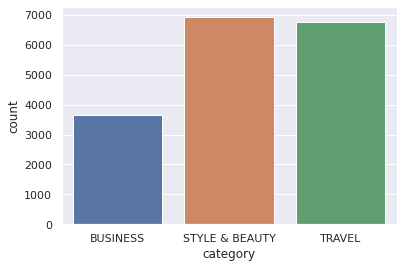

In [13]:
train, test = train_test_split(data, test_size=0.2, random_state=10)
sns.countplot(x=train['category'])

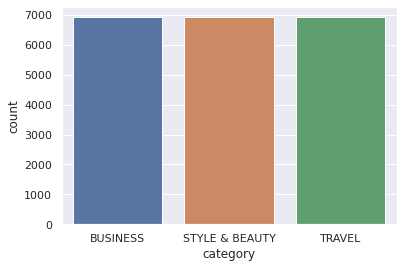

In [14]:
def oversampling(train):
    business = train[train.category == 'BUSINESS']
    style = train[train.category == 'STYLE & BEAUTY']
    travel = train[train.category == 'TRAVEL']

    for i in range(len(style) - len(business)):
        train = train.append(business.sample(), ignore_index=True)

    for i in range(len(style) - len(travel)):
        train = train.append(travel.sample(), ignore_index=True)

    return train

train = oversampling(train)
sns.countplot(x=train['category'])

In [15]:
train_all_word_count = find_probability(train)
train_all_word_count.head()

,travel_count,business_count,style_count,travel_prob,business_prob,style_prob
word,,,,,,
loudmouthed,1,0,0,1.35875e-05,7.19704e-06,7.85349e-06
Federation,0,1,0,6.79376e-06,1.43941e-05,7.85349e-06
longtime,5,1,3,4.07625e-05,1.43941e-05,3.14139e-05
Mills,2,0,0,2.03813e-05,7.19704e-06,7.85349e-06
cluster,5,8,0,4.07625e-05,6.47734e-05,7.85349e-06


In [16]:
result = first_prediction(test, train, train_all_word_count)
result.head()

,category,text_tokens,prediction
10268,TRAVEL,"[Danville, perfect, place, slip, away, city, m...",TRAVEL
20623,TRAVEL,"[Behind, beautiful, brochure, website, describ...",TRAVEL
578,TRAVEL,"[Most, farming, Iceland, raising, animal, gras...",TRAVEL
569,TRAVEL,"[Q, Ill, visiting, Milan, summer, Any, suggest...",TRAVEL
2105,TRAVEL,"[Have, favorite, street, Add, comment, For, li...",TRAVEL


In [17]:
table = first_evaluation(result)
table

,BUSINESS,TRAVEL
Phase 1,,
Recall,0.887902,0.9
Precision,0.825593,0.937731
Accuracy,0.895793,0.895793


In [18]:
result = second_prediction(test, train, train_all_word_count)
result.head()

,category,text_tokens,prediction
10268,TRAVEL,"[Danville, perfect, place, slip, away, city, m...",TRAVEL
20623,TRAVEL,"[Behind, beautiful, brochure, website, describ...",TRAVEL
20297,STYLE & BEAUTY,"[The, president, Wangs, company, Mario, Grauso...",STYLE & BEAUTY
578,TRAVEL,"[Most, farming, Iceland, raising, animal, gras...",TRAVEL
569,TRAVEL,"[Q, Ill, visiting, Milan, summer, Any, suggest...",TRAVEL


In [19]:
table = second_evaluation(result)
table

,BUSINESS,TRAVEL,STYLE & BEAUTY
Phase 2,,,
Recall,0.857936,0.851479,0.830286
Precision,0.734791,0.846969,0.913836
Accuracy,0.844276,0.844276,0.844276


# Confusion matrix
A confusion matrix is a matrix that can be used to measure the performance of an machine learning algorithm. Each column of the confusion matrix represents the instances of an actual class and each row represents the instances of a predicted class. By using this metric we can find out how many of the categories detected truly and how much of them detected wrongly.

In [20]:
from sklearn.metrics import confusion_matrix
def calc_confusion(result):
    actual = result['category'] 
    predicted = result['prediction'] 
    results = confusion_matrix(actual, predicted)

    table = pd.DataFrame([], index=['BUSINESS',  'STYLE & BEAUTY', 'TRAVEL'], columns=['BUSINESS',  'STYLE & BEAUTY', 'TRAVEL'])
    table.loc['BUSINESS']['BUSINESS'] = results[0][0]
    table.loc['BUSINESS']['STYLE & BEAUTY'] = results[1][0]
    table.loc['BUSINESS']['TRAVEL'] = results[2][0]
    table.loc['STYLE & BEAUTY']['BUSINESS'] = results[0][1]
    table.loc['STYLE & BEAUTY']['STYLE & BEAUTY'] = results[1][1]
    table.loc['STYLE & BEAUTY']['TRAVEL'] = results[2][1]
    table.loc['TRAVEL']['BUSINESS'] = results[0][2]
    table.loc['TRAVEL']['STYLE & BEAUTY'] = results[1][2]
    table.loc['TRAVEL']['TRAVEL'] = results[2][2]
    table.index.name = 'Confusion'
    return table

table = calc_confusion(result)
table

,BUSINESS,STYLE & BEAUTY,TRAVEL
Confusion,,,
BUSINESS,773,123,156
STYLE & BEAUTY,42,1453,95
TRAVEL,86,174,1439


# **Final Evaluation**

Now we try our trained data for evaluating the real samples.

In [21]:
fields=['index', 'short_description']
evaluation_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Attachment/test.csv', usecols=fields)
evaluation_test.head()

,index,short_description
0,0,"Now, we're not exactly saying Kate is cutting ..."
1,1,Instagram's Local Lens series is the perfect w...
2,2,NaN
3,3,NaN
4,4,Check out the video on how to get our favorite...


In [22]:
evaluation_test = evaluation_test.dropna()
evaluation_test.head()

,index,short_description
0,0,"Now, we're not exactly saying Kate is cutting ..."
1,1,Instagram's Local Lens series is the perfect w...
4,4,Check out the video on how to get our favorite...
5,5,Want to meet the flesh-and-blood Annie Oakley?...
6,6,The latest line might be coming to us from Cha...


In [23]:
evaluation_test = normalize(evaluation_test)
evaluation_test.head()

,index,text_tokens
0,0,"[Now, exactly, saying, Kate, cutting, loose, t..."
1,1,"[Instagrams, Local, Lens, series, perfect, way..."
4,4,"[Check, video, get, favorite, new, wavy, style..."
5,5,"[Want, meet, fleshandblood, Annie, Oakley, Sum..."
6,6,"[The, latest, line, might, coming, u, Charlize..."


In [24]:
result = second_prediction(evaluation_test, train, train_all_word_count)
result.head()

,index,text_tokens,prediction
0,0,"[Now, exactly, saying, Kate, cutting, loose, t...",STYLE & BEAUTY
1,1,"[Instagrams, Local, Lens, series, perfect, way...",TRAVEL
4,4,"[Check, video, get, favorite, new, wavy, style...",STYLE & BEAUTY
5,5,"[Want, meet, fleshandblood, Annie, Oakley, Sum...",TRAVEL
6,6,"[The, latest, line, might, coming, u, Charlize...",STYLE & BEAUTY


In [0]:
output = pd.DataFrame({"index": result['index'], "category": result['prediction']})
output.to_csv('output.csv', index=False)

# Questions

## 1. lemmatization and stemming differences

I have answered it <a href="#Stemming">here</a>.
## 2. What is tf-idf feature?
Suppose we have a document(or a collection of documents i.e, corpus), and we want to summarize it using a few keywords only. In the end, we want some method to compute the importance of each word.
One way to approach this would be to count the no. of times a word appears in a document. So, the word’s importance is directly proportional to its frequency. This method is, therefore, called Term Frequency(TF).
<img src="Images/1.png" width="320"/>
This method fails in practical use as words like “the”, “an”, “a”, etc. will almost always be the result of this method, as they occur more frequently. But of course, they are not the right way to summarize our document.
We also want to take into consideration how unique the words are, this method is called Inverse Document Frequency(IDF).
<img src="Images/2.png" width="320"/>
So, the product of TF and IDF will give us a measure of how frequent the word is in a document multiplied by how unique the word is, giving rise to Term Frequency-Inverse Document Frequency(TF-IDF) measure.<a href="https://medium.com/@hritikattri10/feature-extraction-using-tf-idf-algorithm-44eedb37305e">[1]</a>
<img src="Images/3.png" width="200"/>

As its shown in the formula, in our model we calculated the TF and we just need to calculate the IDF and multiply it with the TF. So, we can calculate it in the Likelihood.

## 3. What if we just consider precision in the machine learning problem?
If we only use precision for model evaluation, we can get a 100 percent precision if we manage to correctly guess only one poem of the corresponding poet, and predict the other poet for all other given poems.

$$ Precision = \frac{True Positive}{True Positive + False Positive} $$

In other words if we are able to predict one of Hafez's poems correctly and assign it to Hafez and then assign all the other poems to Saadi, the precision for Hafez will be 100%.

## 4. What if we just have one sample of one word in our train data set?

If this situation happen, the probability of one category become zero because it multiply with 0. I have considered this matter and solve it with `Laplace` method. I mention it <a href="#Laplace-Smoothing">here</a>.